In [ ]:
!pip install MedPy

     |████████████████████████████████| 153kB 4.0MB/s 
     |████████████████████████████████| 47.4MB 91kB/s 
  Created wheel for MedPy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754457 sha256=9b7e18c60bcccf074735172834fa1ca0ba225233f440a70bb24fa0248aeda518
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built MedPy


In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K

from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from medpy.io import load
import numpy as np

#import cv2
import nibabel as nib
from PIL import Image

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

False

In [ ]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
    X = Conv2D(num_filters,kernel_size=(kernel_size,kernel_size),strides=(1,1),padding='same')(input_mat)
    if batch_norm:
        X = BatchNormalization()(X)
  
    X = Activation('relu')(X)

    X = Conv2D(num_filters,kernel_size=(kernel_size,kernel_size),strides=(1,1),padding='same')(X)
    if batch_norm:
        X = BatchNormalization()(X)
  
    X = Activation('relu')(X)
    return X
    


def Unet(input_img, n_filters = 16, dropout = 0.2, batch_norm = True):

    c1 = conv_block(input_img,n_filters,3,batch_norm)
    p1 = MaxPooling2D(pool_size=(2, 2), strides=2)(c1)
    p1 = Dropout(dropout)(p1)
  
    c2 = conv_block(p1,n_filters*2,3,batch_norm)
    p2 = MaxPooling2D(pool_size=(2,2) ,strides=2)(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv_block(p2,n_filters*4,3,batch_norm)
    p3 = MaxPooling2D(pool_size=(2,2) ,strides=2)(c3)
    p3 = Dropout(dropout)(p3)
  
    c4 = conv_block(p3,n_filters*8,3,batch_norm)
    p4 = MaxPooling2D(pool_size=(2,2) ,strides=2)(c4)
    p4 = Dropout(dropout)(p4)
  
    c5 = conv_block(p4,n_filters*16,3,batch_norm)

    u6 = Conv2DTranspose(n_filters*8, (3,3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6,c4])
    c6 = conv_block(u6,n_filters*8,3,batch_norm)
    c6 = Dropout(dropout)(c6)
    u7 = Conv2DTranspose(n_filters*4,(3,3),strides = (2,2) , padding= 'same')(c6)

    u7 = concatenate([u7,c3])
    c7 = conv_block(u7,n_filters*4,3,batch_norm)
    c7 = Dropout(dropout)(c7)
    u8 = Conv2DTranspose(n_filters*2,(3,3),strides = (2,2) , padding='same')(c7)
    u8 = concatenate([u8,c2])

    c8 = conv_block(u8,n_filters*2,3,batch_norm)
    c8 = Dropout(dropout)(c8)
    u9 = Conv2DTranspose(n_filters,(3,3),strides = (2,2) , padding='same')(c8)

    u9 = concatenate([u9,c1])

    c9 = conv_block(u9,n_filters,3,batch_norm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=input_img, outputs=outputs)

    return model

In [ ]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def standardize(image):

    standardized_image = np.zeros(image.shape)

    #
    
        # iterate over the `z` dimension
    for z in range(image.shape[2]):
        # get a slice of the image 
        # at channel c and z-th dimension `z`
        image_slice = image[:,:,z]

        # subtract the mean from image_slice
        centered = image_slice - np.mean(image_slice)
        
        # divide by the standard deviation (only if it is different from zero)
        if(np.std(centered)!=0):
            centered = centered/np.std(centered) 

        # update  the slice of standardized image
        # with the scaled centered and scaled image
        standardized_image[:, :, z] = centered

    ### END CODE HERE ###

    return standardized_image

In [ ]:
input_img = Input((240, 240, 1))
model = Unet(input_img,16,0.1,True)
learning_rate = 0.001
epochs = 5000
decay_rate = learning_rate / epochs
model.compile(optimizer=Adam(lr=learning_rate, decay = decay_rate), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
path = 'MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
all_images = os.listdir(path)
all_images.sort()
data = np.zeros((240,240,155,4))
x_to = []
y_to = []

for i in range(len(all_images)):
    x = all_images[i]
    #print(x)
    folder_path = path + '/' + x;
    #print(folder_path)
    modalities = os.listdir(folder_path)
    modalities.sort()
      #data = []
    for j in range(len(modalities)-1):
    #print(modalities[j])
    
        image_path = folder_path + '/' + modalities[j]
        #print(image_path)
        if(image_path[-10:-1] + image_path[-1] == 'seg.nii.gz'):
            img = nib.load(image_path);
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #print("Entered ground truth")
        if(image_path[-12:-1] + image_path[-1] == 'flair.nii.gz'):
            img = nib.load(image_path);
            image_data = img.get_data()
            image_data = np.asarray(image_data)
            image_data = standardize(image_data)
    
    #print(data.shape)
    #print(image_data2.shape)  

    
    for slice_no in range(90,110):
        a = slice_no
        X = image_data[:,:,slice_no]
        #print(a)
        Y = image_data2[:,:,slice_no]
    # imgplot = plt.imshow(X[:,:,2])
    # plt.show(block=False)
    # plt.pause(0.3)
    # plt.close()
  
    # imgplot = plt.imshow(Y)
    # plt.show(block=False)
    # plt.pause(0.3)
    # plt.close()

        if(X.any()!=0 and Y.any()!=0 and len(np.unique(Y)) == 4):
          #print(slice_no)
            x_to.append(X.reshape(240,240,1))
            y_to.append(Y.reshape(240,240,1))
x_to = np.asarray(x_to)
y_to = np.asarray(y_to)        

C:\Users\Ayberk\anaconda3\envs\tff\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
C:\Users\Ayberk\anaconda3\envs\tff\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [ ]:
x_to = np.asarray(x_to).astype("float64")
y_to = np.asarray(y_to).astype("float64")
print(x_to.shape)
print(y_to.shape)

(2981, 240, 240, 1)
(2981, 240, 240, 1)


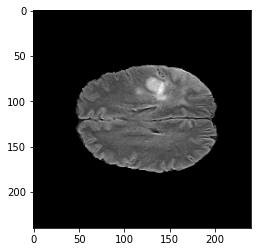

In [ ]:
plt.imshow(x_to[60] , cmap = "gray")

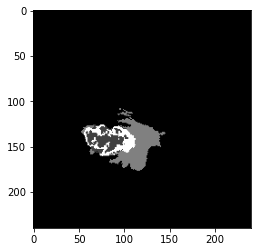

In [ ]:
plt.imshow(y_to[40], cmap = "gray")

In [ ]:
model.fit(x=x_to, y=y_to, batch_size=20, epochs=10)

Epoch 1/10
2981/2981 [==============================] - 126s 42ms/step - loss: 0.4814 - dice_coef: 0.5184
Epoch 2/10
2981/2981 [==============================] - 120s 40ms/step - loss: 0.4223 - dice_coef: 0.5777
Epoch 3/10
2981/2981 [==============================] - 119s 40ms/step - loss: 0.4086 - dice_coef: 0.5913
Epoch 4/10
2981/2981 [==============================] - 119s 40ms/step - loss: 0.4078 - dice_coef: 0.5918
Epoch 5/10
2981/2981 [==============================] - 118s 40ms/step - loss: 0.4036 - dice_coef: 0.5962
Epoch 6/10
2981/2981 [==============================] - 120s 40ms/step - loss: 0.3992 - dice_coef: 0.6023
Epoch 7/10
2981/2981 [==============================] - 120s 40ms/step - loss: 0.3981 - dice_coef: 0.6020
Epoch 8/10
2981/2981 [==============================] - 118s 40ms/step - loss: 0.3959 - dice_coef: 0.6045
Epoch 9/10
2981/2981 [==============================] - 118s 40ms/step - loss: 0.3945 - dice_coef: 0.6065
Epoch 10/10
2981/2981 [=======================

In [ ]:
x_to[0].shape

(240, 240, 1)

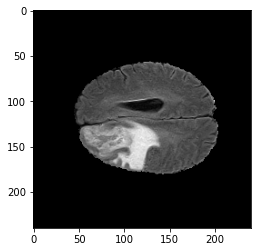

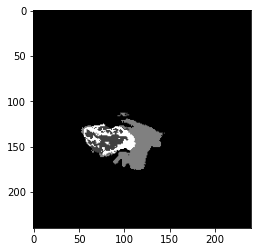

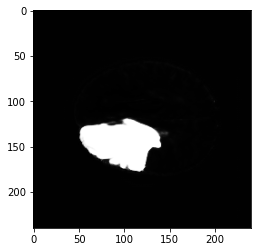

In [ ]:
def predict(image):
    return model.predict(np.asarray([image]) ).reshape((240,240))
idx = 42
img = x_to[idx]
real = y_to[idx]

dispplay(img.reshape((240,240)))
dispplay(real.reshape((240,240)))

pred = predict(img)
dispplay(pred)